In [1]:
%%capture
#!pip install wfdb
BASEPATH = '../'
import sys
sys.path.insert(0,'..')

import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from pyecg.utils import reset_seed, plot_spectogram, plot_loss, load_data
from pyecg.utils import integer_mapping, mapping_AAMI
from pyecg.data_info import *
from pyecg.data_handling import DataHandling
from pyecg.data_preprocessing import DataPreprocessing
from pyecg.report import Reports
from pyecg.models.conv1D import model_arch 

reset_seed()

# Data

In [24]:
#Load Preprocessed data
x_train, y_train = load_data(file_path = '../data/DS1_features_train.dat')
#Load Preprocessed data
x_val, y_val = load_data(file_path = '../data/DS1_features_val.dat')
x_train.shape, len(y_train), x_val.shape, len(y_val)

File loaded: ../data/DS1_features_train.dat
File loaded: ../data/DS1_features_val.dat


((25500, 30, 40), 25500, (25500, 30, 40), 25500)

In [25]:
mean_train = np.mean(x_train)
std_train = np.std(x_train)

from data_handling import stndr

x_train = stndr(x_train, mean_train, std_train)
x_val = stndr(x_val, mean_train, std_train)

In [26]:
dh = DataHandling()
rp1 = dh.report_stats_table([y_train, y_val], ['train','val'])
rp1

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
train,19043,1973,1890,8,8,1842,53,405,1,50,16,207,0,0,4
val,19044,1974,1890,8,8,1841,52,405,1,50,16,207,0,0,4


In [27]:
y_train = mapping_AAMI(y_train, MAP_AAMI)
y_val = mapping_AAMI(y_val, MAP_AAMI)

In [ ]:
rp2 = dh.report_stats_table([y_train, y_val], ['train','val'])
rp2

In [28]:
INT_MAP_DICT = {'N':0,'V':1,'S':2,'F':3,'Q':4}
y_train = integer_mapping(y_train, INT_MAP_DICT)
y_val = integer_mapping(y_val, INT_MAP_DICT)

# Train

In [29]:
params = {
    'seq_len' : x_train.shape[-2],
    'd_model' : x_train.shape[-1],
    'num_heads' : 2,
    'num_classes' : 5,
    'drate' : 0.50,
    'batch_size' : 256,
    'epochs' : 80
}
print(params)

{'seq_len': 30, 'd_model': 40, 'num_heads': 2, 'num_classes': 5, 'drate': 0.5, 'batch_size': 256, 'epochs': 80}


In [30]:
model_classifier  = MultiHeadAttentionClassifier(
                                            seq_len=params['seq_len'],
                                            d_model = params['d_model'],
                                            num_heads = params['num_heads'],
                                            num_classes=params['num_classes'],
                                            drate=params['drate']
                                            )

In [31]:
!rm -r /media/mypc/STORAGE1/codes/heartbeat/checkpoint/keras.EXP1

opt= tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam'
)

#for loss try sample_weight
model_classifier.compile(
                      optimizer=opt,
                      loss="sparse_categorical_crossentropy",
                      metrics=['accuracy'],
                      loss_weights=None
                      )


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5,
                              verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(BASEPATH + "checkpoint/keras.EXP1",
                                                      monitor='val_loss', save_best_only=True, verbose=1)

callbacks = [early_stopping, model_checkpoint, reduce_lr]


In [32]:
%%time

model_history = model_classifier.fit(
              x=x_train,
              y=y_train,
              batch_size=params['batch_size'],
              epochs=params['epochs'],
              verbose=1,
              callbacks=callbacks,
              validation_data=(x_val, y_val),
              shuffle=True,
              class_weight=None,
              sample_weight=None,
              initial_epoch=0
              )

Epoch 1/80
100/100 [==============================] - 7s 72ms/step - loss: 0.3185 - accuracy: 0.9333 - val_loss: 0.1970 - val_accuracy: 0.9522

Epoch 00001: val_loss improved from inf to 0.19696, saving model to ../checkpoint/keras.EXP1
Epoch 2/80
100/100 [==============================] - 7s 71ms/step - loss: 0.1937 - accuracy: 0.9547 - val_loss: 0.1789 - val_accuracy: 0.9584

Epoch 00002: val_loss improved from 0.19696 to 0.17891, saving model to ../checkpoint/keras.EXP1
Epoch 3/80
100/100 [==============================] - 7s 69ms/step - loss: 0.1705 - accuracy: 0.9584 - val_loss: 0.1380 - val_accuracy: 0.9633

Epoch 00003: val_loss improved from 0.17891 to 0.13805, saving model to ../checkpoint/keras.EXP1
Epoch 4/80
100/100 [==============================] - 7s 70ms/step - loss: 0.1566 - accuracy: 0.9612 - val_loss: 0.1306 - val_accuracy: 0.9653

Epoch 00004: val_loss improved from 0.13805 to 0.13063, saving model to ../checkpoint/keras.EXP1
Epoch 5/80
100/100 [====================


Epoch 00038: val_loss did not improve from 0.06959
Epoch 39/80
100/100 [==============================] - 8s 80ms/step - loss: 0.0819 - accuracy: 0.9779 - val_loss: 0.0670 - val_accuracy: 0.9831

Epoch 00039: val_loss improved from 0.06959 to 0.06697, saving model to ../checkpoint/keras.EXP1
Epoch 40/80
100/100 [==============================] - 8s 84ms/step - loss: 0.0821 - accuracy: 0.9784 - val_loss: 0.0630 - val_accuracy: 0.9831

Epoch 00040: val_loss improved from 0.06697 to 0.06300, saving model to ../checkpoint/keras.EXP1
Epoch 41/80
100/100 [==============================] - 8s 79ms/step - loss: 0.0807 - accuracy: 0.9789 - val_loss: 0.0683 - val_accuracy: 0.9822

Epoch 00041: val_loss did not improve from 0.06300
Epoch 42/80
100/100 [==============================] - 9s 86ms/step - loss: 0.0776 - accuracy: 0.9793 - val_loss: 0.0692 - val_accuracy: 0.9825

Epoch 00042: val_loss did not improve from 0.06300
Epoch 43/80
100/100 [==============================] - 9s 87ms/step - lo

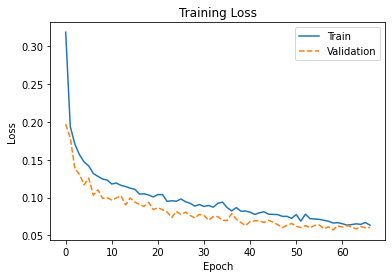

In [33]:
plot_loss(model_history)

In [34]:
import pickle
with open(BASEPATH+'history/EXP1.hist', 'wb') as f:
  pickle.dump(model_history.history, f)


In [35]:
a =model_history.history
min(a['val_loss']), a['val_loss'].index(min(a['val_loss']))

(0.05719318240880966, 58)

# Loading Model

In [36]:
loaded_model = tf.keras.models.load_model(BASEPATH+'checkpoint/keras.EXP1')
loaded_model.name

'multi_head_attention_classifier_1'

In [37]:
#loaded_model.summary()

In [38]:
#Load Preprocessed Test Set
x_test, y_test = load_data(file_path = '../data/DS2_features.dat')
y_true = y_test.copy()
x_test.shape, len(y_test)

File loaded: ../data/DS2_features.dat


((49693, 30, 40), 49693)

In [39]:
y_true = mapping_AAMI(y_true, MAP_AAMI)

In [40]:
x_test = stndr(x_test, mean_train, std_train)

In [41]:
%%time
y_pred_prob = loaded_model.predict(x_test)

CPU times: user 6.93 s, sys: 194 ms, total: 7.12 s
Wall time: 6.76 s


In [42]:
y_pred = integer_mapping(list(y_pred_prob.argmax(axis=-1)), INT_MAP_DICT, inverse=True)

In [43]:
dh = DataHandling()
rp2 = dh.report_stats_table([y_pred, y_true], ['y_pred','y_true'])
rp2

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
y_pred,44623,0,0,0,0,4471,0,0,389,0,0,207,0,0,3
y_true,44241,0,0,0,0,3220,0,0,1837,0,0,388,0,0,7


In [44]:
labels = [k for k,v in INT_MAP_DICT.items()]
report = Reports(y_true=y_true, y_pred=y_pred, labels=labels)
normalize = None
#report.plot_confusion_matrix(normalize=normalize, values_format='')
print(report.the_classification_report())
#report.metrics_table()


y_pred_AAMI = mapping_AAMI(y_pred, MAP_AAMI)
y_true_AAMI = mapping_AAMI(y_true, MAP_AAMI)
labels_AAMI = ['N','V','S','F','Q']
report = Reports(y_true=y_true_AAMI, y_pred=y_pred_AAMI, labels=labels_AAMI)
#report.plot_confusion_matrix(normalize=normalize, values_format='')
print(report.the_classification_report())
report.metrics_table()


              precision    recall  f1-score   support

           F     0.0048    0.0026    0.0034       388
           N     0.9501    0.9583    0.9542     44241
           Q     0.0000    0.0000    0.0000         7
           S     0.1568    0.0332    0.0548      1837
           V     0.6242    0.8668    0.7258      3220

    accuracy                         0.9106     49693
   macro avg     0.3472    0.3722    0.3476     49693
weighted avg     0.8921    0.9106    0.8986     49693

              precision    recall  f1-score   support

           F     0.0048    0.0026    0.0034       388
           N     0.9501    0.9583    0.9542     44241
           Q     0.0000    0.0000    0.0000         7
           S     0.1568    0.0332    0.0548      1837
           V     0.6242    0.8668    0.7258      3220

    accuracy                         0.9106     49693
   macro avg     0.3472    0.3722    0.3476     49693
weighted avg     0.8921    0.9106    0.8986     49693



,Class,(PPV)Precision,(Sensitivity)Recall,Specificity,Accuracy
0,F,0.48,0.26,99.58,98.81
1,N,95.01,95.83,59.13,91.80
2,Q,0.00,0.00,99.99,99.98
3,S,15.68,3.32,99.31,95.77
4,V,62.42,86.68,96.38,95.76
